## First Simulation Study

### Load Libraries

In [12]:
import numpy as np
import scipy.stats as stats

##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# Library for Gaussian process
import GPy

##Library for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 
import re

In [13]:
# split into input (X) and output (Y) variables
N = 1000 ##Sample Size
P = 1 ##Covariates
M = 100 ##replicates
X = np.array([np.ones(N)]).T ##Design matrix

kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function,C(s, s′) = σ^2 exp{−|s − s′|/ρ}, 方差超参数 σ^2=1, 缩放超参数 ρ = 0.1
noise_var = 0.01 ##Nugget variance

# 生成训练数据 1000 points evenly spaced over [0,1]
s = np.linspace(0,1,N).reshape(-1,1) ## 距离样本，间距为 1/N
mu = np.ones(N).reshape(-1,1) ## 列数为 1， 行数根据数组大小自动计算 vector of the means
nugget = np.eye(N) * noise_var ##对角的块金矩阵 Nugget matrix
cov_mat = kernel.K(s) + nugget ##按照指定核生成含噪声的协方差矩阵 Covariance matrix



# Generate M sample path with mean mu and covariance C
# 用预定义的高斯过程生成 M 个样本路径，每个样本路径对应于高斯过程的一个实例

np.random.seed(1)
y = np.random.multivariate_normal(mu[:,0],cov_mat,M).T 
## 根据预定义的高斯过程（1000个训练点），生成 M 个样本（注：每个样本代表一个函数实例），
## 最终 y 为 1000 x 100， 每一列对应一个独立的函数样本
## 每一行代表一个输入对应的 M 个样本，根据高斯过程的定义，这些样本应当来自于该位置处的边缘高斯分布

In [14]:
print(y.shape) ##check the dimension of y

(1000, 100)


### Visualize the Observation

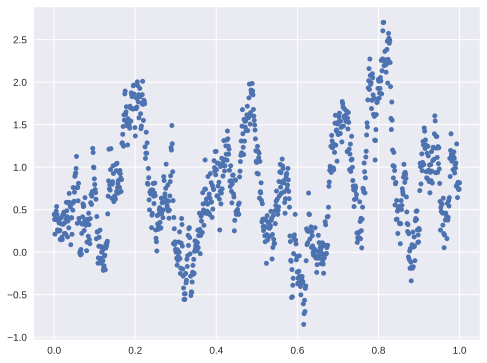

In [15]:
from scipy import stats

plt.plot(s,y[:,99],".",mew=1.5) ## 绘制第 0 列
plt.show()

# kde = stats.gaussian_kde(y[1:])
# plt.plot(
# plt.show()

### Create a neural network with three hidden layers
#plt.savefig("trueGP.pdf")
         
         

### Create a neural network with seven hidden layers

In [16]:
def create_mlp_7(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim,  kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model### Create a neural network with 7 hidden layers

### Generate basis functions

In [17]:
num_basis = [10,19,37,73]  ## 为 4 个分辨率层级分别设置 knots 数， 所以基函数的总数为 sum(num_basis)
knots = [np.linspace(0,1,i) for i in num_basis]  ## 为每个分辨率层级分别生成 knots 构成的规则网格

K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)): ## 对于每一个分辨率层级
    theta = 1/num_basis[res]*2.5  ## 定义缩放参数
    for i in range(num_basis[res]):  ## 对于每一个 knot
        d = np.absolute(s - knots[res][i])/theta ## 分别计算所有输入到该 knot 的距离
        for j in range(len(d)): ## 为所有输入计算与该 knot 之间的协方差， 采用 Wendland kernel
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3 ## 
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]
    
    ## 结果： 
    ## K 为基函数的综述，对于本例为 139
    ## phi 保存了所有输入 s 到所有分辨率 knots 之间的协方差，因为共设计了 1000 个输入点，所以 1000 x 139
    

Check the dimension of $s$, $X$, $y$ and $\phi$

In [18]:
print(s.shape)
print(X.shape)
print(y.shape)
print(phi.shape)

(1000, 1)
(1000, 1)
(1000, 100)
(1000, 139)


### Split the data

In [19]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)

## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_train, phi_test\
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, X, phi, y, indices, test_size=0.2)

N_train = s_train.shape[0]
N_test = s_test.shape[0]

** Only with X=1 **

In [20]:
model_1 = create_mlp_7(feature_dim = P)
 
# train the model
print("[INFO] training model 1...")
model_1.fit(X_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 1...


** With s and X **

In [21]:
model_2 = create_mlp_7(feature_dim = P + 1)
Xs_train = np.hstack((X_train,s_train)) 
# train the model
print("[INFO] training model 2...")
model_2.fit(Xs_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 2...


** With RBF and X **

In [22]:
model_3 = create_mlp_7(feature_dim = P + K)
XRBF_train = np.hstack((X_train,phi_train)) 
# train the model
print("[INFO] training model 3...")
train_history = model_3.fit(XRBF_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 3...


In [25]:
Xs = np.hstack((X,s))
XRBF = np.hstack((X,phi))
y0_test_1 = model_1.predict(X)
y0_test_2 = model_2.predict(Xs)
y0_test_3 = model_3.predict(XRBF)

32/32 [==============================] - 0s 2ms/step


In [26]:
print([y0_test_1.shape,y0_test_2.shape,y0_test_3.shape])

[(1000, 1), (1000, 1), (1000, 1)]


### Truth from GP

In [28]:

##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
m = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train], kernel, noise_var = noise_var)
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y0_gp = mu_GP + mu

In [29]:
print(y0_gp.shape)

(1000, 1)


In [30]:
kernel2 = GPy.kern.Matern32(1,1,1)
m2 = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train],kernel2, noise_var = noise_var)
m2.optimize()
mu_GPE,var_GPE = m2.predict(s)
lo95_GPE,up95_GPE = m2.predict_quantiles(s)
y0_gpe = mu_GPE + mu

In [31]:
print(y0_gpe.shape)

(1000, 1)


### Visualize results

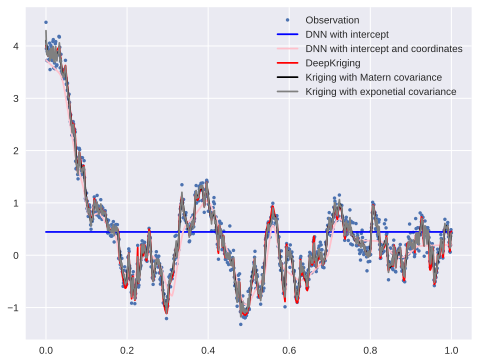

In [32]:
pylab.plot(s, y[:,0],".",label="Observation")
pylab.plot(s, y0_test_1,'blue',label="DNN with intercept")
pylab.plot(s, y0_test_2,'pink',label="DNN with intercept and coordinates")
pylab.plot(s, y0_test_3,'red',label="DeepKriging")
pylab.plot(s, y0_gpe,'black',label="Kriging with Matern covariance")
pylab.plot(s, y0_gp,'grey',label="Kriging with exponetial covariance")
pylab.legend(loc='upper right')
pylab.show()
#plt.savefig("1D_compare.pdf")

### MSE, MAE, and Nonlinearity

In [33]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return float(rmse)
def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return float(mape)

In [ ]:
rmse_train_combine = np.zeros((5,M))
mape_train_combine = np.zeros((5,M))
rmse_test_combine = np.zeros((5,M))
mape_test_combine = np.zeros((5,M))

for i in range(M):
    print("[INFO] training %s-th replicate..." % (i+1))
    ##Kriging with exponential covariance
    m = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)], kernel, noise_var = noise_var)
    mu_GP_train,var_GP_train = m.predict(s_train)
    y_gp_train = mu_GP_train
    mu_GP_test,var_GP_test = m.predict(s_test)
    y_gp_test = mu_GP_test
    
    ##Kriging with Matern covariance
    kernel2 = GPy.kern.Matern32(1,1,1)
    m2 = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)],kernel2, noise_var = noise_var)
    m2.optimize()
    mu_GPE_train,var_GPE_train = m2.predict(s_train)
    y_gpe_train = mu_GPE_train
    mu_GPE_test,var_GPE_test = m2.predict(s_test)
    y_gpe_test = mu_GPE_test
 
    ##DNN with intercept
    model_1.fit(X_train, y_train[:,i], epochs = 500, batch_size = 32, verbose = 0)
    y_dnn_train = model_1.predict(X[idx_train,:])
    y_dnn_test = model_1.predict(X[idx_test,:])
 
    ##DNN with intercept and coordinate
    model_2.fit(Xs_train, y_train[:,i], epochs = 500, batch_size = 32, verbose = 0)
    y_dnn2_train = model_2.predict(Xs[idx_train,:])
    y_dnn2_test = model_2.predict(Xs[idx_test,:])
    
    ##DeepKriging with seven hidden layers
    model_3.fit(XRBF_train, y_train[:,i], epochs = 200, batch_size = 32, verbose = 0)
    y_dk_train = model_3.predict(XRBF[idx_train,:])
    y_dk_test = model_3.predict(XRBF[idx_test,:])
    
   
    ##Save the results
    rmse_train_combine[:,i] = np.array([rmse(y_train[:,i],y_gp_train[:,0]),\
                                  rmse(y_train[:,i],y_gpe_train[:,0]),\
                                  rmse(y_train[:,i],y_dk_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn2_train[:,0])])
    mape_train_combine[:,i] = np.array([mape(y_train[:,i],y_gp_train[:,0]),\
                                  mape(y_train[:,i],y_gpe_train[:,0]),\
                                  mape(y_train[:,i],y_dk_train[:,0]),\
                                  mape(y_train[:,i],y_dnn_train[:,0]),\
                                  mape(y_train[:,i],y_dnn2_train[:,0])])
    rmse_test_combine[:,i] = np.array([rmse(y_test[:,i],y_gp_test[:,0]),\
                                  rmse(y_test[:,i],y_gpe_test[:,0]),\
                                  rmse(y_test[:,i],y_dk_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn2_test[:,0])])
    mape_test_combine[:,i] = np.array([mape(y_test[:,i],y_gp_test[:,0]),\
                                  mape(y_test[:,i],y_gpe_test[:,0]),\
                                  mape(y_test[:,i],y_dk_test[:,0]),\
                                  mape(y_test[:,i],y_dnn_test[:,0]),\
                                  mape(y_test[:,i],y_dnn2_test[:,0])])

    print(rmse_train_combine[:,i])
    print(mape_train_combine[:,i])
    
    print(rmse_test_combine[:,i])
    print(mape_test_combine[:,i])

[INFO] training 1-th replicate...
7/7 [==============================] - 0s 2ms/step
[0.06129266 0.12853187 0.0987145  1.05372663 0.23428232]
[0.49460374 0.97930201 0.85793017 5.68477764 1.73758958]
[0.16240056 0.17262673 0.17749654 0.94440113 0.24513356]
[1.00559322 0.8668522  1.28343571 5.37626347 1.52561717]
[INFO] training 2-th replicate...
7/7 [==============================] - 0s 2ms/step
[0.06487197 0.1289624  0.10032545 1.22966169 0.21529029]
[0.14317066 0.30875918 0.20470504 2.42396309 0.42128763]
[0.17087402 0.17874351 0.17857126 1.24565209 0.23295828]
[0.22024285 0.23343728 0.22116376 1.60699933 0.28165553]
[INFO] training 3-th replicate...
7/7 [==============================] - 0s 2ms/step
[0.06126816 0.1243449  0.08287457 0.76207335 0.18485952]
[0.2570759  0.50730061 0.32604056 3.32341645 0.63971889]
[0.15002992 0.15691694 0.1598155  0.84500903 0.19948014]
[0.31518999 0.39775478 0.3487185  2.64576701 0.4982352 ]
[INFO] training 4-th replicate...


In [ ]:
print(np.mean(rmse_train_combine,axis=1))
print(np.std(rmse_train_combine,axis=1))
print(np.mean(mape_train_combine,axis=1))
print(np.std(mape_train_combine,axis=1))

In [ ]:
print(np.mean(rmse_train_combine,axis=1))
print(np.std(rmse_train_combine,axis=1))
print(np.mean(mape_train_combine,axis=1))
print(np.std(mape_train_combine,axis=1))